<a href="https://colab.research.google.com/github/allfed/CropOpt/blob/standardize/notebooks/yield_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# These Instructions Are Only Needed The First Time You Setup CoLab

In [ ]:
# We must clone the code repo into your Colab environment in order to use it.
# To do this we must first connect your GitHub account via this online command line.
# This block generates an SSH key which you'll add to your GitHub account.
!ssh-keygen -t rsa -b 4096 -f ~/.ssh/id_rsa -N '' <<< y

Generating public/private rsa key pair.
Enter file in which to save the key (/home/dmrivers/.ssh/id_rsa): 

In [4]:
!ssh-keyscan -t rsa github.com >> /root/.ssh/known_hosts

/bin/bash: /root/.ssh/known_hosts: Permission denied


In [ ]:
# This line prints the key. Copy the key to your clipboard.
!cat /root/.ssh/id_rsa.pub

In [ ]:
# Now, navigate to https://github.com/settings/keys and click "New SSH key"
# Copy paste the above into the "Key" field, and give it a title, e.g. "Colab key",
# then save the key. Once done, test using this line:
!ssh -T git@github.com

In [ ]:
## Now we can clone the repo using SSH
!rm -rf allfed-integrated-model/
!git clone -b main git@github.com:allfed/allfed-integrated-model.git

In [3]:
# This adds the Python files in our repo to our path so we can import
# them

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path) 

In [ ]:
# Now we'll install other dependencies from our Poetry file. We do this by first
# installing the toml package so we can read the pyproject.toml file
!pip install toml

In [ ]:
# We then load the file and read our required packages from it
import toml
config = toml.load("allfed-integrated-model/pyproject.toml")
pip_packages = config["tool"]["poetry"]["dependencies"]

In [ ]:
# Finally, we install the packages

import subprocess
import sys

def install_pip_package(package, version):
    subprocess.check_call([sys.executable, "-m", "pip", "install", f"{package}=={version}"],"-U")

for package, version in pip_packages.items():
    if package == "python":
        continue
    install_pip_package(package, version.replace("^",""))

# Optimizer calculation demo

The purpose of this file is to allow researchers to run the optimizer with differing assumptions. Please reach out to morgan@allfed.info if you have questions about this code.

First, let's import the Optimizer, which runs through the code to optimize the minimum people fed of calories, fat, and protein. 

In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/home/dmrivers/Code/allfed-integrated-model


In [8]:
from src.optimizer import Optimizer
from src.plotter import Plotter

Set all the more speculative constants for the optimization.

In [9]:

constants = {}
constants['inputs'] = {}

constants['inputs']['NMONTHS'] = 24
constants['inputs']['LIMIT_SEAWEED_AS_PERCENT_KCALS'] = True

constants['inputs']['ASSUMED_WASTE_PERCENT'] = 35
constants['inputs']['ASSUMED_WASTE_PERCENT_M1'] = 35
constants['inputs']['ASSUMED_WASTE_PERCENT_AFTER_M1'] = 30
# constants['inputs']['ALL_BIOFUEL'] = 22e6#tons dry caloric equivalent
constants['inputs']['M1_ADDITIONAL_WASTE'] = 5e9/12#tons dry caloric equivalent
constants['inputs']['NUTRITION']={}
constants['inputs']['NUTRITION']['KCALS_DAILY'] = 2100 #kcals per person per day
constants['inputs']['NUTRITION']['FAT_DAILY'] = 35 #grams per person per day
constants['inputs']['NUTRITION']['PROTEIN_DAILY'] = 51 #grams per person per day

constants['inputs']['INITIAL_MILK_COWS'] = 264e6
constants['inputs']['MAX_SEAWEED_AS_PERCENT_KCALS'] = 10
constants['inputs']['INIT_SMALL_ANIMALS'] = 28.2e9
constants['inputs']['INIT_MEDIUM_ANIMALS'] = 3.2e9
constants['inputs']['INIT_LARGE_ANIMALS'] = 1.9e9
constants['inputs']['HARVEST_LOSS'] = 15 # percent (seaweed)
constants['inputs']['INITIAL_SEAWEED'] = 1 # 1000 tons (seaweed)
constants['inputs']['INITIAL_AREA'] = 1 # 1000 tons (seaweed)
constants['inputs']['NEW_AREA_PER_DAY'] = 4.153 # 1000 km^2 (seaweed)
constants['inputs']['MINIMUM_DENSITY'] = 400 #tons/km^2 (seaweed)
constants['inputs']['MAXIMUM_DENSITY'] = 4000 #tons/km^2 (seaweed)
constants['inputs']['MAXIMUM_AREA'] = 1000 # 1000 km^2 (seaweed)
constants['inputs']['SEAWEED_PRODUCTION_RATE'] = 10 # percent (seaweed)
constants['inputs']['TONS_DRY_CALORIC_EQIVALENT_SF'] = 1602542*1000.
constants['inputs']['INITIAL_SF_PROTEIN'] = 203607 #1000 tons protein per unit mass initial
constants['inputs']['INITIAL_SF_FAT'] = 63948 # 1000 tons fat per unit mass initial
constants['inputs']['GREENHOUSE_FAT_MULTIPLIER'] = 2
constants['inputs']['RATIO_KCALS_POSTDISASTER']={}
constants['inputs']['RATIO_KCALS_POSTDISASTER']['Y1'] = 0.4
constants['inputs']['RATIO_KCALS_POSTDISASTER']['Y2'] = 0.2
constants['inputs']['RATIO_KCALS_POSTDISASTER']['Y3'] = 0.2
constants['inputs']['RATIO_KCALS_POSTDISASTER']['Y4'] = 0.2
constants['inputs']['DAIRY_PRODUCTION'] = 0.5 #multiplies current dairy productivity (based on stress of animals)
constants['inputs']['GREENHOUSE_FAT_MULTIPLIER'] = 2 # we can grow twice as much fat as greenhouses would have
constants['inputs']['GREENHOUSE_SLOPE_MULTIPLIER'] = 1 #default values from greenhouse paper
constants['inputs']['OUTDOOR_GROWING_FAT_MULTIPLIER'] = 2 # we can grow twice as much fat as we would have
constants['inputs']['CELLULOSIC_SUGAR_SLOPE_MULTIPLIER'] = 1 #default values from CS paper


constants['inputs']['ADD_FISH'] = True
constants['inputs']['ADD_SEAWEED'] = True
constants['inputs']['ADD_CELLULOSIC_SUGAR'] = True
constants['inputs']['ADD_GREENHOUSES'] = True
constants['inputs']['ADD_NONEGG_NONDAIRY_MEAT'] = True
constants['inputs']['ADD_DAIRY'] = True
constants['inputs']['ADD_STORED_FOOD'] = True
constants['inputs']['ADD_OUTDOOR_GROWING'] = True

constants['CHECK_CONSTRAINTS'] = False


Run the optimizer, optimizer result validation, and generate analysis

In [10]:
optimizer = Optimizer()

[time_months,time_months_middle,analysis]=optimizer.optimize(constants)



VALIDATION


pulp reports successful optimization

Nutrients with constraining values are: ['fat']
Estimated people fed is 1.7732619 billion


/home/dmrivers/.cache/pypoetry/virtualenvs/allfed-integrated-model-KHCin7Rg-py3.7/lib/python3.7/site-packages/pulp/apis/coin_api.py:87: UserWarning: Parameter fracGap is being depreciated for gapRel
  warnings.warn("Parameter fracGap is being depreciated for gapRel")


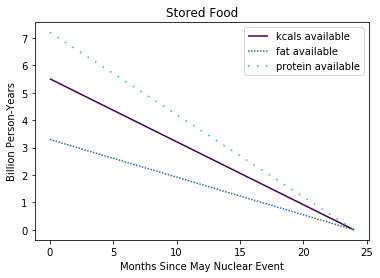

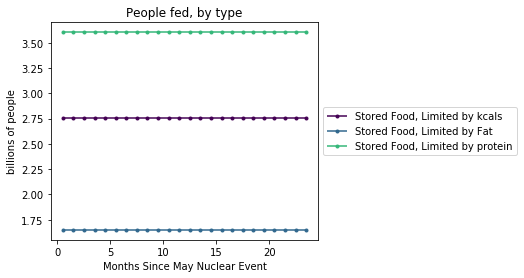

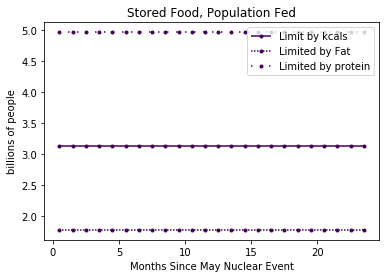

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


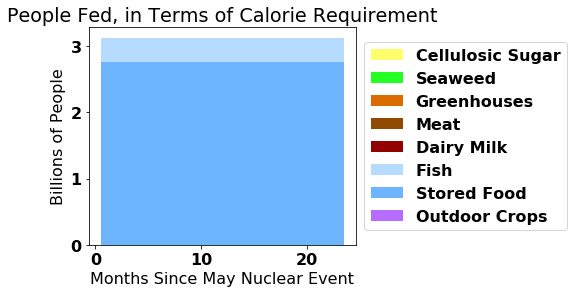

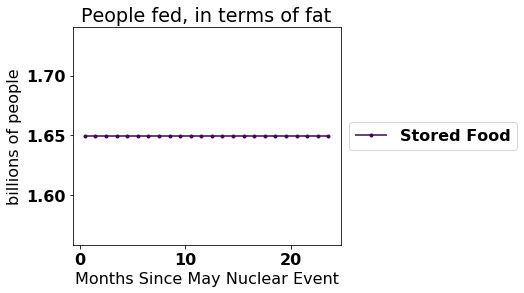

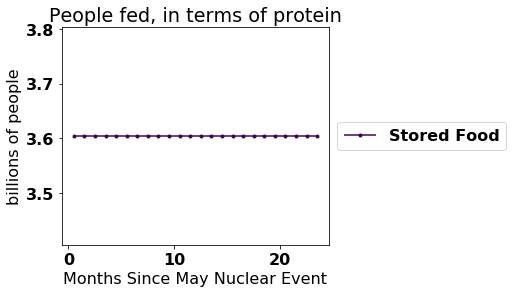

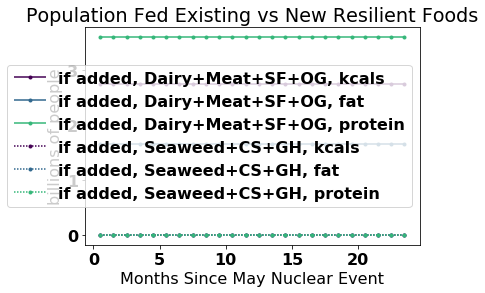

In [11]:
if(constants['inputs']['ADD_CELLULOSIC_SUGAR']):
    Plotter.plot_CS(time_months_middle,analysis)

if(constants['inputs']['ADD_FISH']):
    Plotter.plot_fish(time_months_middle,analysis)

if(constants['inputs']['ADD_GREENHOUSES']):
    Plotter.plot_GH(time_months_middle,analysis)

if(constants['inputs']['ADD_OUTDOOR_GROWING']):
    Plotter.plot_OG(time_months_middle,analysis)

if(constants['inputs']['ADD_STORED_FOOD']):
    Plotter.plot_stored_food(time_months,analysis)

if(constants['inputs']['ADD_SEAWEED']):
    Plotter.plot_seaweed(time_months_middle,analysis)

if(constants['inputs']['ADD_NONEGG_NONDAIRY_MEAT']):
    Plotter.plot_nonegg_nondairy_meat(time_months,analysis)

if(constants['inputs']['ADD_DAIRY']):
    Plotter.plot_dairy_cows(time_months_middle,analysis)
    Plotter.plot_dairy(time_months_middle,analysis)

Plotter.plot_people_fed(time_months_middle,analysis)
Plotter.plot_people_fed_combined(time_months_middle,analysis)
Plotter.plot_people_fed_kcals(time_months_middle,analysis)
Plotter.plot_people_fed_fat(time_months_middle,analysis)
Plotter.plot_people_fed_protein(time_months_middle,analysis)
Plotter.plot_people_fed_comparison(time_months_middle,analysis)